In [1]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator


class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [2]:

ehi_information = """Title: EHI: End-to-end Learning of Hierarchical Index for
Efficient Dense Retrieval
Summary: Dense embedding-based retrieval is now the industry
standard for semantic search and ranking problems, like obtaining relevant web
documents for a given query. Such techniques use a two-stage process: (a)
contrastive learning to train a dual encoder to embed both the query and
documents and (b) approximate nearest neighbor search (ANNS) for finding similar
documents for a given query. These two stages are disjoint; the learned
embeddings might be ill-suited for the ANNS method and vice-versa, leading to
suboptimal performance. In this work, we propose End-to-end Hierarchical
Indexing -- EHI -- that jointly learns both the embeddings and the ANNS
structure to optimize retrieval performance. EHI uses a standard dual encoder
model for embedding queries and documents while learning an inverted file index
(IVF) style tree structure for efficient ANNS. To ensure stable and efficient
learning of discrete tree-based ANNS structure, EHI introduces the notion of
dense path embedding that captures the position of a query/document in the tree.
We demonstrate the effectiveness of EHI on several benchmarks, including
de-facto industry standard MS MARCO (Dev set and TREC DL19) datasets. For
example, with the same compute budget, EHI outperforms state-of-the-art (SOTA)
in by 0.6% (MRR@10) on MS MARCO dev set and by 4.2% (nDCG@10) on TREC DL19
benchmarks.
Author(s): Ramnath Kumar, Anshul Mittal, Nilesh Gupta, Aditya Kusupati,
Inderjit Dhillon, Prateek Jain
Source: https://arxiv.org/pdf/2310.08891.pdf"""

In [3]:

from langchain_core.tools import tool

@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of artificial intelligence (AI).
    Cannot be used to research any other topics. Search query must be provided
    in natural language and be verbose."""
    # this is a "RAG" emulator
    return ehi_information

@tool("final_answer")
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`, and a
    `source` which provides citations for where this information came from.
    """
    return ""

In [4]:

search_tool

StructuredTool(name='search', description='Searches for information on the topic of artificial intelligence (AI).\n    Cannot be used to research any other topics. Search query must be provided\n    in natural language and be verbose.', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search_tool at 0x7f703df279c0>)

In [5]:

import os
from langchain.agents import create_openai_tools_agent
from langchain import hub
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

llm = ChatGroq(groq_api_key=os.environ['GROQ_API_KEY'], model_name="llama3-70b-8192")

prompt = hub.pull("hwchase17/openai-functions-agent")

query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)

/home/fermikira/anaconda3/envs/llms_env/lib/python3.12/site-packages/langsmith/client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/home/fermikira/anaconda3/envs/llms_env/lib/python3.12/site-packages/langsmith/client.py:5519: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [6]:

inputs = {
    "input": "what are EHI embeddings?",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'EHIs'}, log="\nInvoking: `search` with `{'query': 'EHIs'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tedv', 'function': {'arguments': '{"query":"EHIs"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 1081, 'total_tokens': 1124, 'completion_time': 0.135486554, 'prompt_time': 0.071533631, 'queue_time': 0.004702308000000002, 'total_time': 0.207020185}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ad3befe-1ffa-43ac-b078-aa3f84a70c16-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHIs'}, 'id': 'call_tedv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1081, 'output_tokens': 43, 'total_tokens': 1124})], tool_call_id='call_tedv')]

In [7]:

from langchain_core.agents import AgentFinish
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    print(agent_out)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    print(str(out))
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

# this forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    print(function_call)
    return {"agent_out": function_call}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    print(function_call)
    return {"agent_out": function_call}

In [8]:

from langgraph.graph import StateGraph

graph = StateGraph(AgentState)

# we have four nodes that will consume our agent state and modify
# our agent state based on some internal process
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our graph will always begin with the query agent
graph.set_entry_point("query_agent")

In [9]:

from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    source ="query_agent",   # function to determine which node is called
    path = router,
    path_map = {
        "search": "search",
        "error": "error",
        "final_answer": END
    }
)
graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runnable = graph.compile()

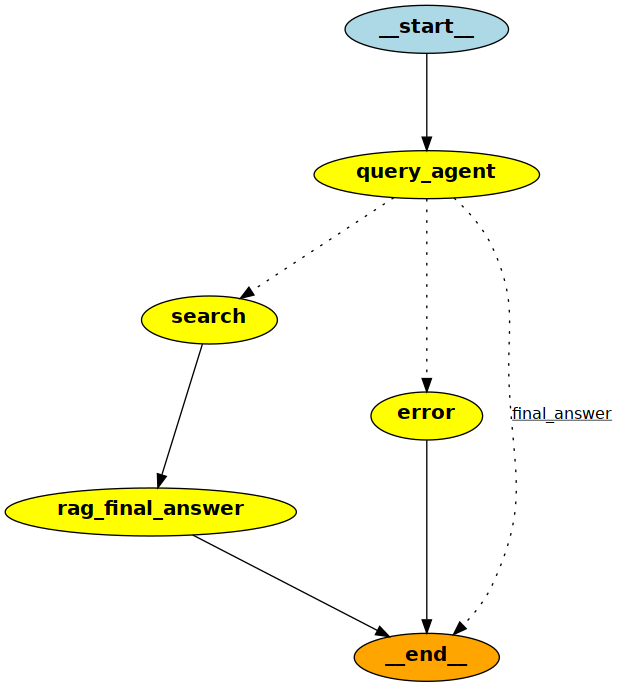

In [10]:

from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [11]:

runnable = graph.compile()

out = runnable.invoke({
    "input": "what is AI?",
    "chat_history": []
})
     

> run_query_agent
[ToolAgentAction(tool='search', tool_input={'query': 'What is AI'}, log="\nInvoking: `search` with `{'query': 'What is AI'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0577', 'function': {'arguments': '{"query":"What is AI"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 1079, 'total_tokens': 1123, 'completion_time': 0.139432341, 'prompt_time': 0.065407442, 'queue_time': 0.708929838, 'total_time': 0.204839783}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ed4f473f-5ec5-4fe6-8aa4-f0446f494e9c-0', tool_calls=[{'name': 'search', 'args': {'query': 'What is AI'}, 'id': 'call_0577', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1079, 'output_tokens': 44, 'total_tokens': 1123})], tool_call_id='call_0577')]
> router
> execute_search
Title: EHI: End-to-end Learning 

In [12]:

print(out["agent_out"])


{"answer":"AI, or Artificial Intelligence, refers to the development of computer systems that can perform tasks that typically require human intelligence, such as understanding language, recognizing images, making decisions, and solving problems.","source":"Based on general knowledge"}


In [13]:
out = runnable.invoke({
    "input": "can you tell me about EHI embeddings?",
    "chat_history": []
})
print(out["agent_out"])
     

> run_query_agent
[ToolAgentAction(tool='search', tool_input={'query': 'EHI embeddings'}, log="\nInvoking: `search` with `{'query': 'EHI embeddings'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8ra0', 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 1084, 'total_tokens': 1128, 'completion_time': 0.134519457, 'prompt_time': 0.089601098, 'queue_time': 0.004739258999999996, 'total_time': 0.224120555}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-717f8dcf-e71e-4bbb-9ad5-ce20ebde96bc-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHI embeddings'}, 'id': 'call_8ra0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1084, 'output_tokens': 44, 'total_tokens': 1128})], tool_call_id='call_8ra0')]
> router
> execute_search
Title: 

In [14]:
out = runnable.invoke({
    "input": "hi",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
[ToolAgentAction(tool='search', tool_input={'query': 'hi'}, log="\nInvoking: `search` with `{'query': 'hi'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_18qx', 'function': {'arguments': '{"query":"hi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 1076, 'total_tokens': 1118, 'completion_time': 0.131436949, 'prompt_time': 0.07575905, 'queue_time': 0.079354482, 'total_time': 0.207195999}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_753a4aecf6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d756034a-d822-42d5-8cae-bf2bfa992abd-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi'}, 'id': 'call_18qx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 42, 'total_tokens': 1118})], tool_call_id='call_18qx')]
> router
> execute_search
Title: EHI: End-to-end Learning of Hierarchical Index for
Efficie

# Prueba ahora si del flujo

##      Funciones

In [1]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator


class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [2]:
@tool
def buscar():
    
    return 'xd'

NameError: name 'tool' is not defined

In [19]:
from langchain_core.agents import AgentFinish
import json
from datetime import datetime

# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

def validado(state: list):
    print("> validado")
    state["validado"] =  "si"
    print(state)
    agent_out = "Validado el cliente"
    return state
    
def info_credito(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""Always say that this is a specific credit information

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}


def info_general(state: list):
    from MilvusRetriever import MilvusRetriever
    r = MilvusRetriever(documents=[],k=3)
    r.init()
    print("> final_answer")
    query = state["input"]  
    
    context = state["intermediate_steps"][-1]

    prompt = f"""Always say that it is a general information

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

def satisfecho(state: list):
    print("> satisfecho")
    satisfecho = state["input"]
    return {"satisfecho": satisfecho }

def encuesta(state: list):
    print("> encuesta")
    return "encuesta"

def agendar_sac(state: list):
    print("> agendar sac")
    return "agendar_sac"

def timer_5min(state:list):
    print("> timer_5min")
    return "encuesta"

def satisfecho_router(state: list):
    print("> satisfecho_router")
    if state["satisfecho"] == "si":
        return "encuesta"
    else: 
        return "agendar_sac"
    
def router(state: list):
    print("> router")
    print(state)
    if state["validado"] == "si":
        return "info_credito"
    else:
        return "info_general"


def router_time(state:list):
    print("> router_time")
    if state["input"]:
        return "validado"
    else:
        return "encuesta"

## Grafica

In [20]:
from langgraph.graph import StateGraph, END
import time
import threading


graph = StateGraph(AgentState)
graph.set_conditional_entry_point
# Definir los estados
graph.add_node("validado", validado)
graph.add_node("info_credito", info_credito)
graph.add_node("info_general", info_general)
graph.add_node("satisfecho", satisfecho)
graph.add_node("encuesta", encuesta)
graph.add_node("agendar_sac", agendar_sac)
graph.add_node("timer_5min", timer_5min)

# Conditional edges are controlled by our router
graph.set_conditional_entry_point(
    path=router_time,
    path_map={
        "validado": "validado",
        "timer_5min": "timer_5min"
    }
)


# Conditional edges are controlled by our router
graph.add_conditional_edges(
    source="validado",   # function to determine which node is called
    path=router,
    path_map={
        "info_credito": "info_credito",
        "info_general": "info_general"
    }
)

graph.add_edge("info_credito", "satisfecho")
graph.add_edge("info_general", "satisfecho")

# Configurar transiciones a partir de "timer_5min"
graph.add_conditional_edges(
    source="satisfecho",   # function to determine which node is called
    path=satisfecho_router,
    path_map={
        "encuesta": "encuesta",
        "agendar_sac": "agendar_sac"
    }
)
graph.add_edge("timer_5min", "encuesta")
graph.add_edge("satisfecho", "encuesta")
graph.add_edge("encuesta", END)
graph.add_edge("agendar_sac", END)

runnable = graph.compile()


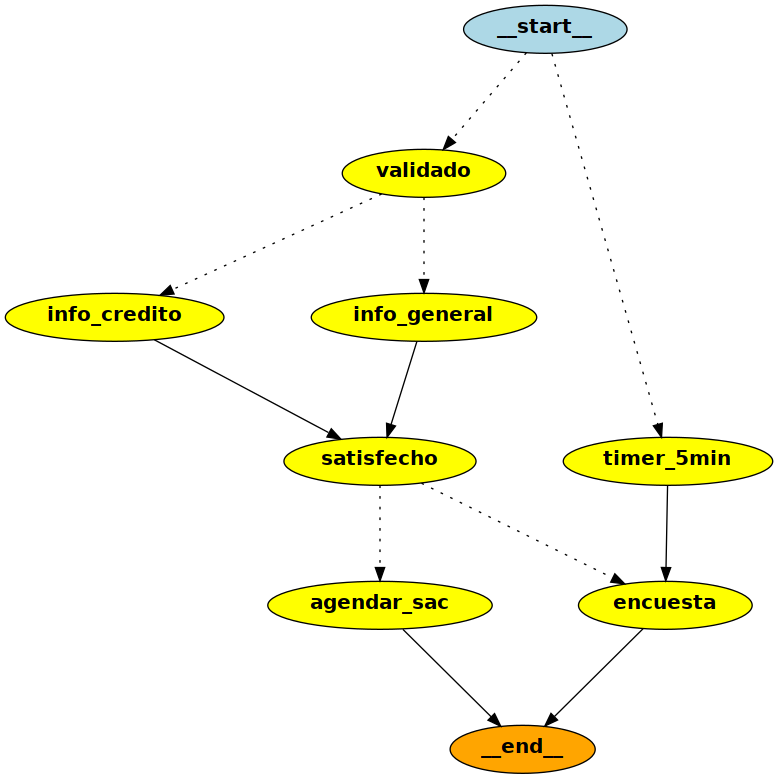

In [21]:
from IPython.display import Image
Image(runnable.get_graph().draw_png())

In [29]:
graph.compile()